There are many deep-learning libraries in Julia. One of the most used one is Flux.jl  
*"Relax! Flux is the ML library that doesn't make you tensor https://fluxml.ai/"*

In [2]:
using Flux
model = Chain(
  Dense(10, 5, σ),
  Dense(5, 2),
  softmax)

model(rand(10))

Tracked 2-element Array{Float32,1}:
 0.16757292f0
 0.832427f0  

In [3]:
using Flux, Flux.Tracker

W = param(rand(2, 5))
b = param(rand(2))

predict(x) = W*x .+ b
loss(x, y) = sum((predict(x) .- y).^2)

x, y = rand(5), rand(2) # Dummy data
l = loss(x, y) # ~ 3

θ = Params([W, b])
grads = Tracker.gradient(() -> loss(x, y), θ)

Grads(...)


In [4]:
using Flux.Tracker: grad, update!

η = 0.1 # Learning Rate
for p in (W, b)
  update!(p, -η * grads[p])
end

Running this will alter the parameters W and b and our loss should go down. Flux provides a more general way to do optimiser updates like this.

In [7]:
opt = Descent(0.1) # Gradient descent with learning rate 0.1

for p in (W, b)
  update!(opt, p, grads[p])
end

# Training
To actually train a model we need three things:

- A objective function, that evaluates how well a model is doing given some input data.
- A collection of data points that will be provided to the objective function.
- An optimiser that will update the model parameters appropriately.
With these we can call Flux.train!:  
`Flux.train!(objective, params, data, opt)`

In [8]:
m = Chain(
  Dense(784, 32, σ),
  Dense(32, 10), softmax)

loss(x, y) = Flux.mse(m(x), y)
ps = Flux.params(m)

# later
Flux.train!(loss, ps, data, opt)

UndefVarError: UndefVarError: data not defined

# Datasets
The data argument provides a collection of data to train with (usually a set of inputs `x` and target outputs `y`). For example, here's a dummy data set with only one data point:

In [10]:
x = rand(784)
y = rand(10)
data = [(x, y)]

1-element Array{Tuple{Array{Float64,1},Array{Float64,1}},1}:
 ([0.939566, 0.000264101, 0.646587, 0.877392, 0.365939, 0.686855, 0.547145, 0.90546, 0.148181, 0.000112474  …  0.152099, 0.241316, 0.729375, 0.362262, 0.241207, 0.321071, 0.081579, 0.539145, 0.621858, 0.330482], [0.215777, 0.170623, 0.867348, 0.267223, 0.745106, 0.280507, 0.919499, 0.56173, 0.272965, 0.918508])

Flux.train! will call `loss(x, y)`, calculate gradients, update the weights and then move on to the next data point if there is one. We can train the model on the same data three times:

In [11]:
data = [(x, y), (x, y), (x, y)]
# Or equivalently
data = Iterators.repeated((x, y), 3)

Base.Iterators.Take{Base.Iterators.Repeated{Tuple{Array{Float64,1},Array{Float64,1}}}}(Base.Iterators.Repeated{Tuple{Array{Float64,1},Array{Float64,1}}}(([0.939566, 0.000264101, 0.646587, 0.877392, 0.365939, 0.686855, 0.547145, 0.90546, 0.148181, 0.000112474  …  0.152099, 0.241316, 0.729375, 0.362262, 0.241207, 0.321071, 0.081579, 0.539145, 0.621858, 0.330482], [0.215777, 0.170623, 0.867348, 0.267223, 0.745106, 0.280507, 0.919499, 0.56173, 0.272965, 0.918508])), 3)

It's common to load the xs and ys separately. In this case you can use zip:

In [12]:
xs = [rand(784), rand(784), rand(784)]
ys = [rand( 10), rand( 10), rand( 10)]
data = zip(xs, ys)

Base.Iterators.Zip{Tuple{Array{Array{Float64,1},1},Array{Array{Float64,1},1}}}((Array{Float64,1}[[0.08294, 0.608878, 0.443501, 0.94554, 0.022552, 0.664766, 0.848742, 0.879386, 0.666702, 0.715114  …  0.981416, 0.089761, 0.393361, 0.634776, 0.670174, 0.821625, 0.766537, 0.594076, 0.547374, 0.107182], [0.342504, 0.481631, 0.386382, 0.860105, 0.227784, 0.00965336, 0.240138, 0.302572, 0.30479, 0.907426  …  0.343283, 0.137797, 0.27948, 0.525597, 0.0364411, 0.793045, 0.145359, 0.458839, 0.408409, 0.76181], [0.42895, 0.977434, 0.446811, 0.68652, 0.326125, 0.77806, 0.0470123, 0.734319, 0.472213, 0.864425  …  0.879248, 0.950281, 0.958001, 0.689371, 0.54214, 0.640526, 0.299305, 0.389577, 0.954926, 0.776146]], Array{Float64,1}[[0.470541, 0.0898159, 0.826808, 0.301025, 0.632179, 0.327187, 0.0288924, 0.781422, 0.277394, 0.221102], [0.400823, 0.795952, 0.812812, 0.155874, 0.584326, 0.477461, 0.612816, 0.225555, 0.583877, 0.0566462], [0.342955, 0.255601, 0.662287, 0.571431, 0.405345, 0.824443, 0.86603

Note that, by default, train! only loops over the data once (a single "epoch"). A convenient way to run multiple epochs from the REPL is provided by `@epochs`.

# Example -- Time series clustering 
Say we have a bunch of $n$ time series of length $T$ collected in matrix $A \in \mathbb{R^{T\times m}}$

Can we decompose $A$ as a combination of "basis time series"?

This is exactly what SVD does $A = U(SV^T)$. If we keep only the $k$ largest singular value/vector pairs, we have a low-rank approximation (the number of basis time series is lower than the number of measured time series.

What if we want a sparse decomposition?
$$A = WH$$ where $h$ is sparse.

What if we want each time series $a_i = W h_i$ to be not only sparse in $h_i$, but that $h_i$ lives on the probability simplex
$$h_i \geq 0, \quad \sum h_i = 1$$
This would allow us to say that $a_i$ is 10% of one base vector and 90% of another one, etc.

Dirichlet process prior on $h_i \sim Dirichlet(\alpha)$

One can solve this problem using Bayesian non-parametrics, but it takes forever (I have tried)

One can also just maximize
$$|| A - WH|| - (\alpha -1)\sum H$$

To make sure $h_i$ stays on the probability simplex, we optimize over $\bar h_i$ and calculate $h_i = softmax(\bar h_i)$

We start by creating some data

In [177]:
using Flux, Flux.Tracker
using Flux.Tracker: data

m,n,k = 20,10,3

W = randn(m,k)
H = softmax(5randn(k,n))
A = W*H
H

3×10 Array{Float64,2}:
 0.00831866  0.000744661  0.997767    …  2.29878e-6  0.109209    0.183599
 0.98913     0.0106785    0.00223258     0.999972    0.00203771  0.27081 
 0.00255108  0.988577     6.90386e-7     2.59751e-5  0.888753    0.545591

We can try the SVD method first

In [178]:
function rank_k_svd(A,k)
    s = svd(A)
    Wsvd, Hsvd = s.U[:,1:k], s.Vt[1:k,:]
    Asvd = Wsvd*Diagonal(s.S[1:k])*Hsvd
    Wsvd,Hsvd,Asvd
end

Wsvd,Hsvd,Asvd = rank_k_svd(A,k)
@assert norm(A-Asvd)/norm(A) < 1e-10
Hsvd

3×10 Array{Float64,2}:
  0.180947   -0.465293    0.0313793  …   0.183876   -0.416331  -0.202391 
 -0.539701   -0.12009    -0.0963735     -0.544519   -0.114197  -0.228003 
 -0.0674251  -0.0898799   0.893118      -0.0754595   0.016941   0.0944101

The resulting $H$ is dense and hard to interpret

We now set up and solve the stated optimization problem using Flux 

In [190]:
α = 0.2
Wh,Hh = param(randn(m,k+1)), param(randn(k+1,n))
p = params(Wh,Hh)
dir(H,α) = (α-1)*sum(log, H)
function cost()
    H = softmax(Hh)
    norm(A-Wh*H) - dir(H,α) # Negative likelihood
end

cost (generic function with 1 method)

We then create an optimizer and run gradient-based training for a number of iterations

In [191]:
opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [192]:
@time for i = 1:2000
    gs = Tracker.gradient(cost, p)
    Flux.Optimise.update!(opt, p, gs)
end
Ah = (Wh*softmax(Hh)).data
@show norm(A-Asvd)/norm(A)
@show norm(A-Ah)/norm(A)

  0.295312 seconds (1.00 M allocations: 77.218 MiB, 4.62% gc time)
norm(A - Asvd) / norm(A) = 7.085300869999581e-16
norm(A - Ah) / norm(A) = 0.555804894124887


0.555804894124887

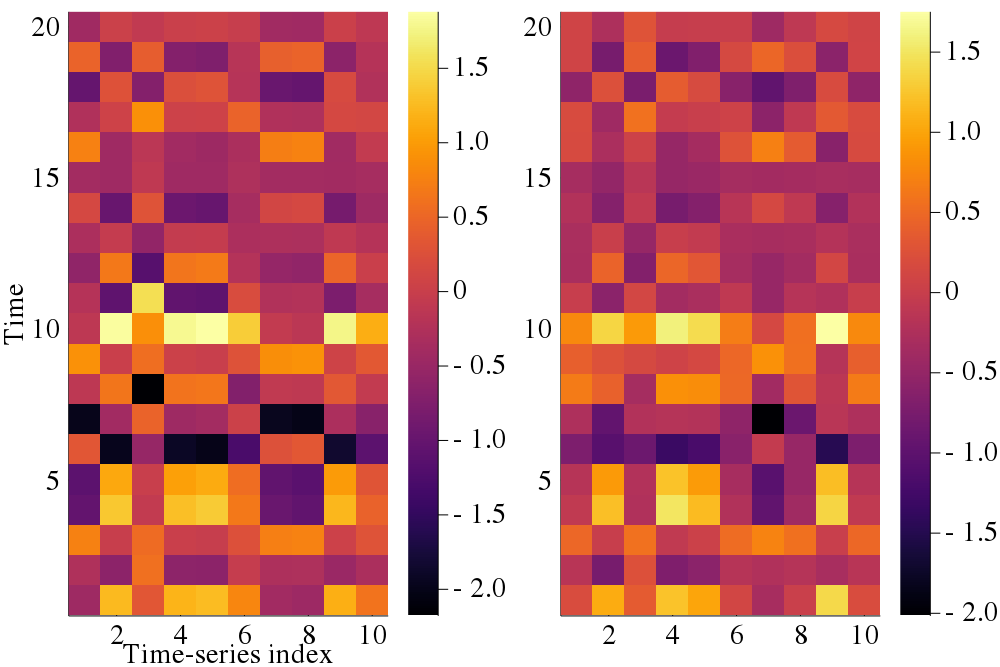

In [193]:
heatmap(A, layout=2, ylabel="Time", xlabel="Time-series index"); heatmap!(Ah, subplot=2)

How well does our decomposition approximate the original time series?

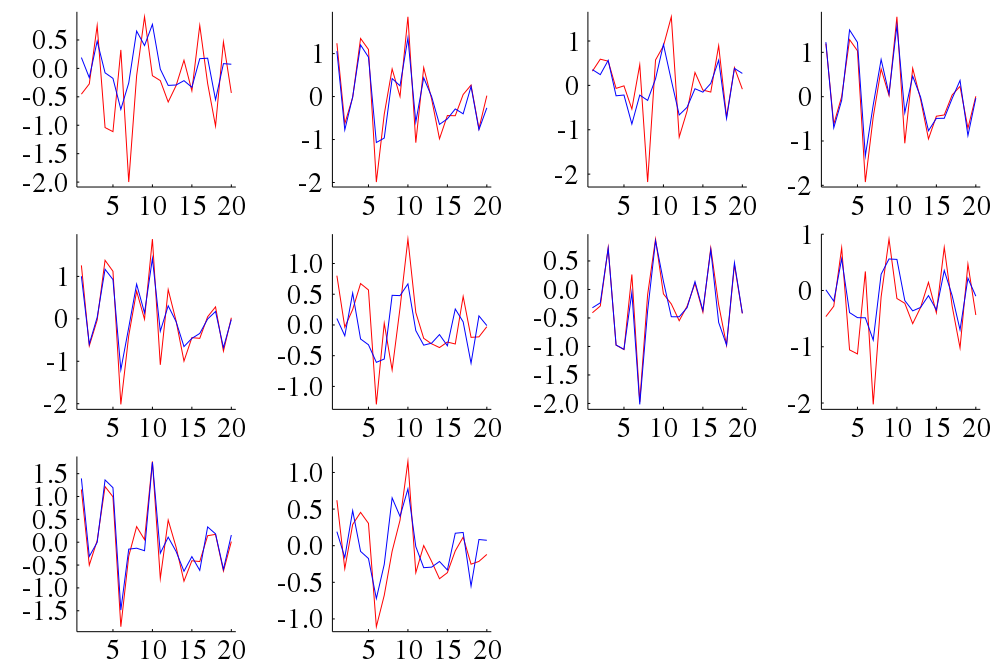

In [194]:
plot(A, c=:red, layout=10); plot!(Ah, c=:blue)

Just for fun, let's look at the basis functions

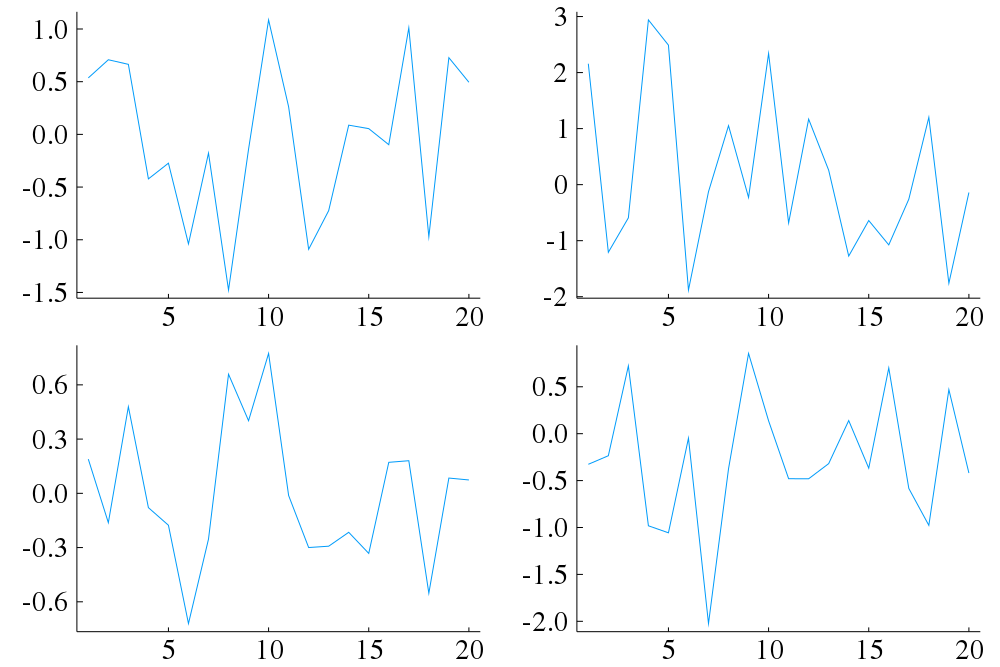

In [200]:
plot(Wh.data, layout=size(Wh,2))

Now, let's see if the resulting $H$ is sparse

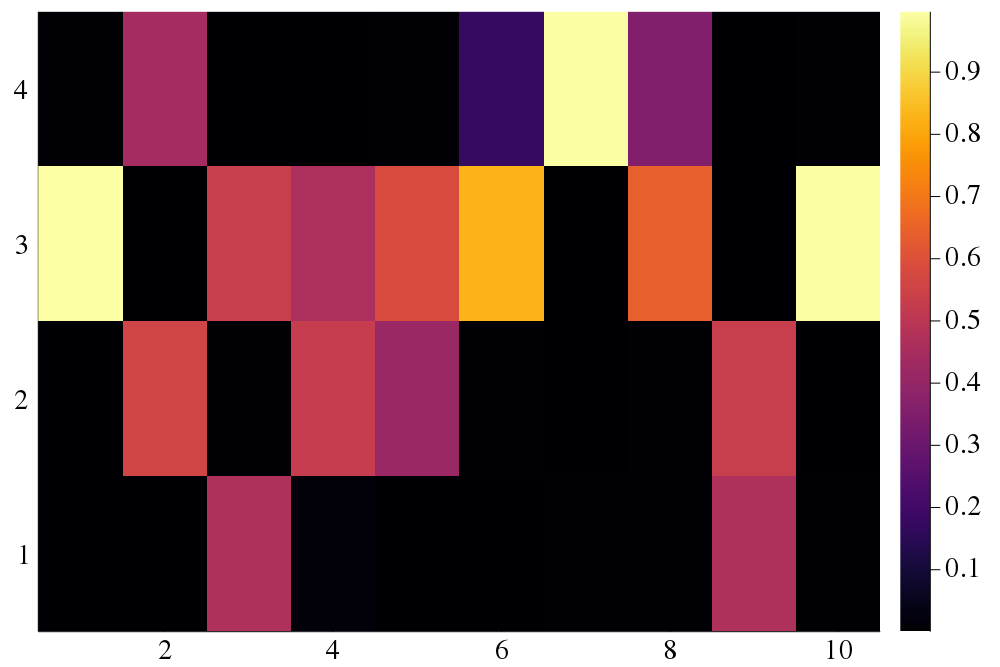

In [195]:
heatmap(softmax(Hh).data)

To see if we have used too many basis functions, we see if there are strong correlations between them.

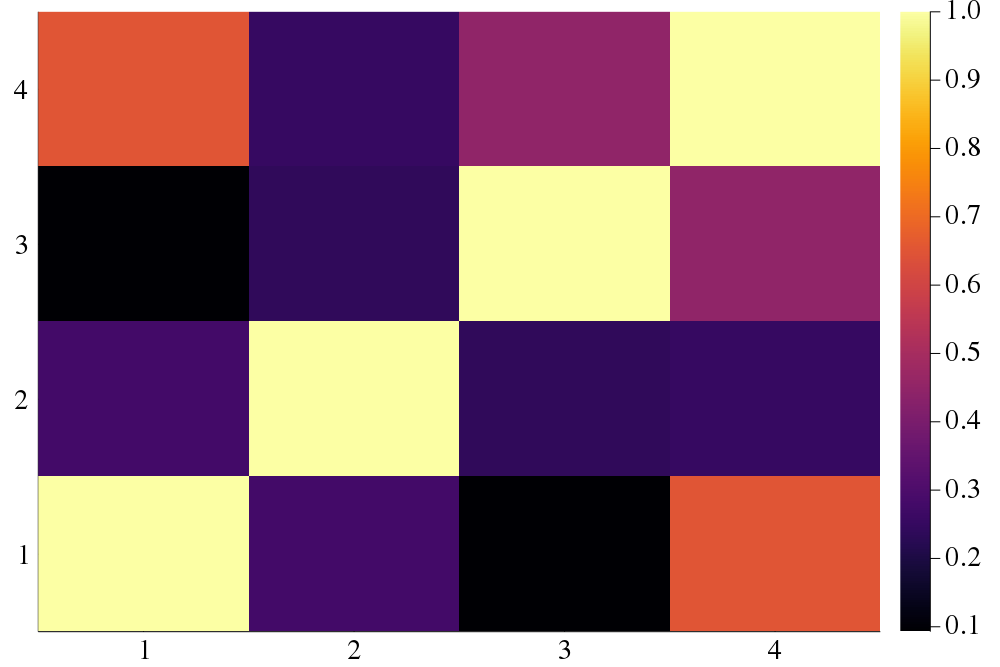

In [203]:
heatmap(abs.(cor(Hh.data')))